<a href="https://colab.research.google.com/github/pacesatuinineh/Wavelet-Filter/blob/main/PipelineMRIkaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import needed libraries

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
tr_df = train_df('/content/drive/MyDrive/datasetWajahsplit/Training')

In [6]:
tr_df

Class Path    Class
0     /content/drive/MyDrive/datasetWajahsplit/Train...   Kokoda
1     /content/drive/MyDrive/datasetWajahsplit/Train...   Kokoda
2     /content/drive/MyDrive/datasetWajahsplit/Train...   Kokoda
3     /content/drive/MyDrive/datasetWajahsplit/Train...   Kokoda
4     /content/drive/MyDrive/datasetWajahsplit/Train...   Kokoda
...                                                 ...      ...
1709  /content/drive/MyDrive/datasetWajahsplit/Train...  Aitinyo
1710  /content/drive/MyDrive/datasetWajahsplit/Train...  Aitinyo
1711  /content/drive/MyDrive/datasetWajahsplit/Train...  Aitinyo
1712  /content/drive/MyDrive/datasetWajahsplit/Train...  Aitinyo
1713  /content/drive/MyDrive/datasetWajahsplit/Train...  Aitinyo

[1714 rows x 2 columns]

In [7]:
ts_df = test_df('/content/drive/MyDrive/datasetWajahsplit/Testing')

In [8]:
ts_df

Class Path   Class
0    /content/drive/MyDrive/datasetWajahsplit/Testi...     Moi
1    /content/drive/MyDrive/datasetWajahsplit/Testi...     Moi
2    /content/drive/MyDrive/datasetWajahsplit/Testi...     Moi
3    /content/drive/MyDrive/datasetWajahsplit/Testi...     Moi
4    /content/drive/MyDrive/datasetWajahsplit/Testi...     Moi
..                                                 ...     ...
725  /content/drive/MyDrive/datasetWajahsplit/Testi...  Kokoda
726  /content/drive/MyDrive/datasetWajahsplit/Testi...  Kokoda
727  /content/drive/MyDrive/datasetWajahsplit/Testi...  Kokoda
728  /content/drive/MyDrive/datasetWajahsplit/Testi...  Kokoda
729  /content/drive/MyDrive/datasetWajahsplit/Testi...  Kokoda

[730 rows x 2 columns]

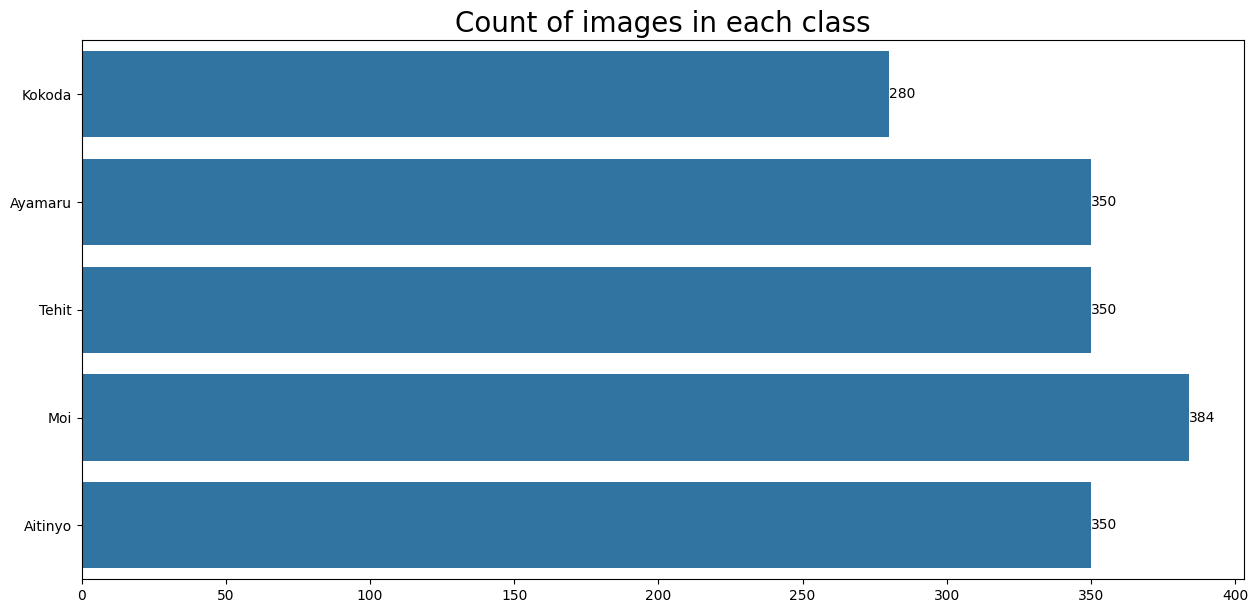

In [9]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

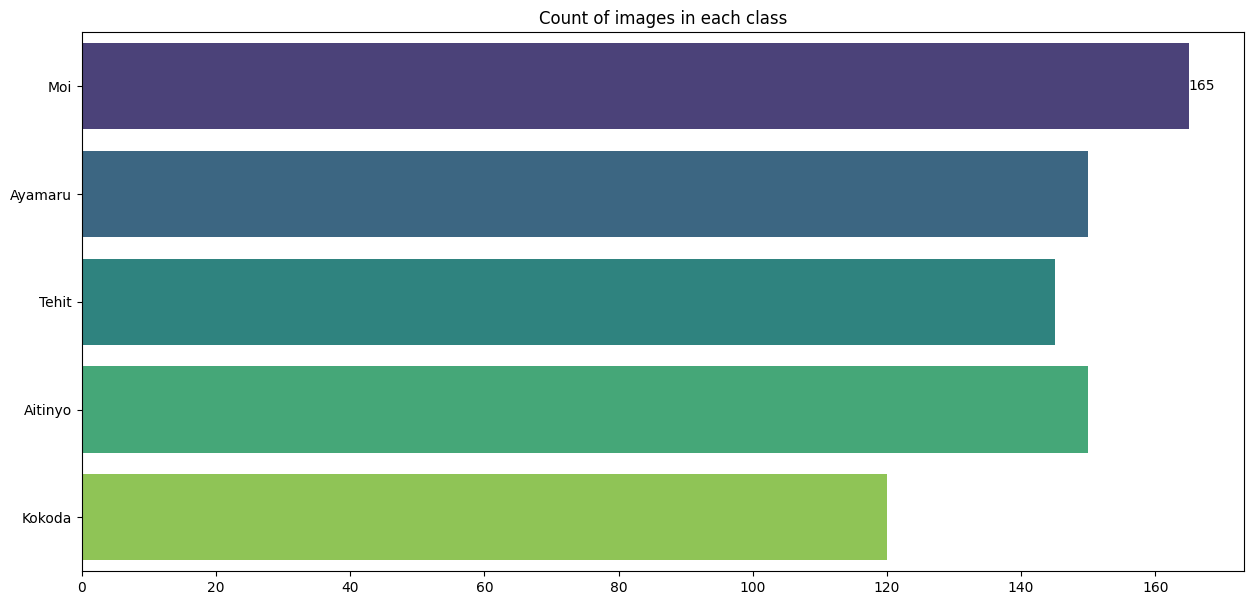

In [10]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [11]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [12]:
valid_df

Class Path    Class
442  /content/drive/MyDrive/datasetWajahsplit/Testi...    Tehit
30   /content/drive/MyDrive/datasetWajahsplit/Testi...      Moi
122  /content/drive/MyDrive/datasetWajahsplit/Testi...      Moi
664  /content/drive/MyDrive/datasetWajahsplit/Testi...   Kokoda
525  /content/drive/MyDrive/datasetWajahsplit/Testi...  Aitinyo
..                                                 ...      ...
336  /content/drive/MyDrive/datasetWajahsplit/Testi...    Tehit
697  /content/drive/MyDrive/datasetWajahsplit/Testi...   Kokoda
456  /content/drive/MyDrive/datasetWajahsplit/Testi...    Tehit
547  /content/drive/MyDrive/datasetWajahsplit/Testi...  Aitinyo
163  /content/drive/MyDrive/datasetWajahsplit/Testi...      Moi

[365 rows x 2 columns]

## 2.3 Data preprocessing

In [13]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 1714 validated image filenames belonging to 5 classes.
Found 365 validated image filenames belonging to 5 classes.
Found 365 validated image filenames belonging to 5 classes.


## 2.4 Getting samples from data

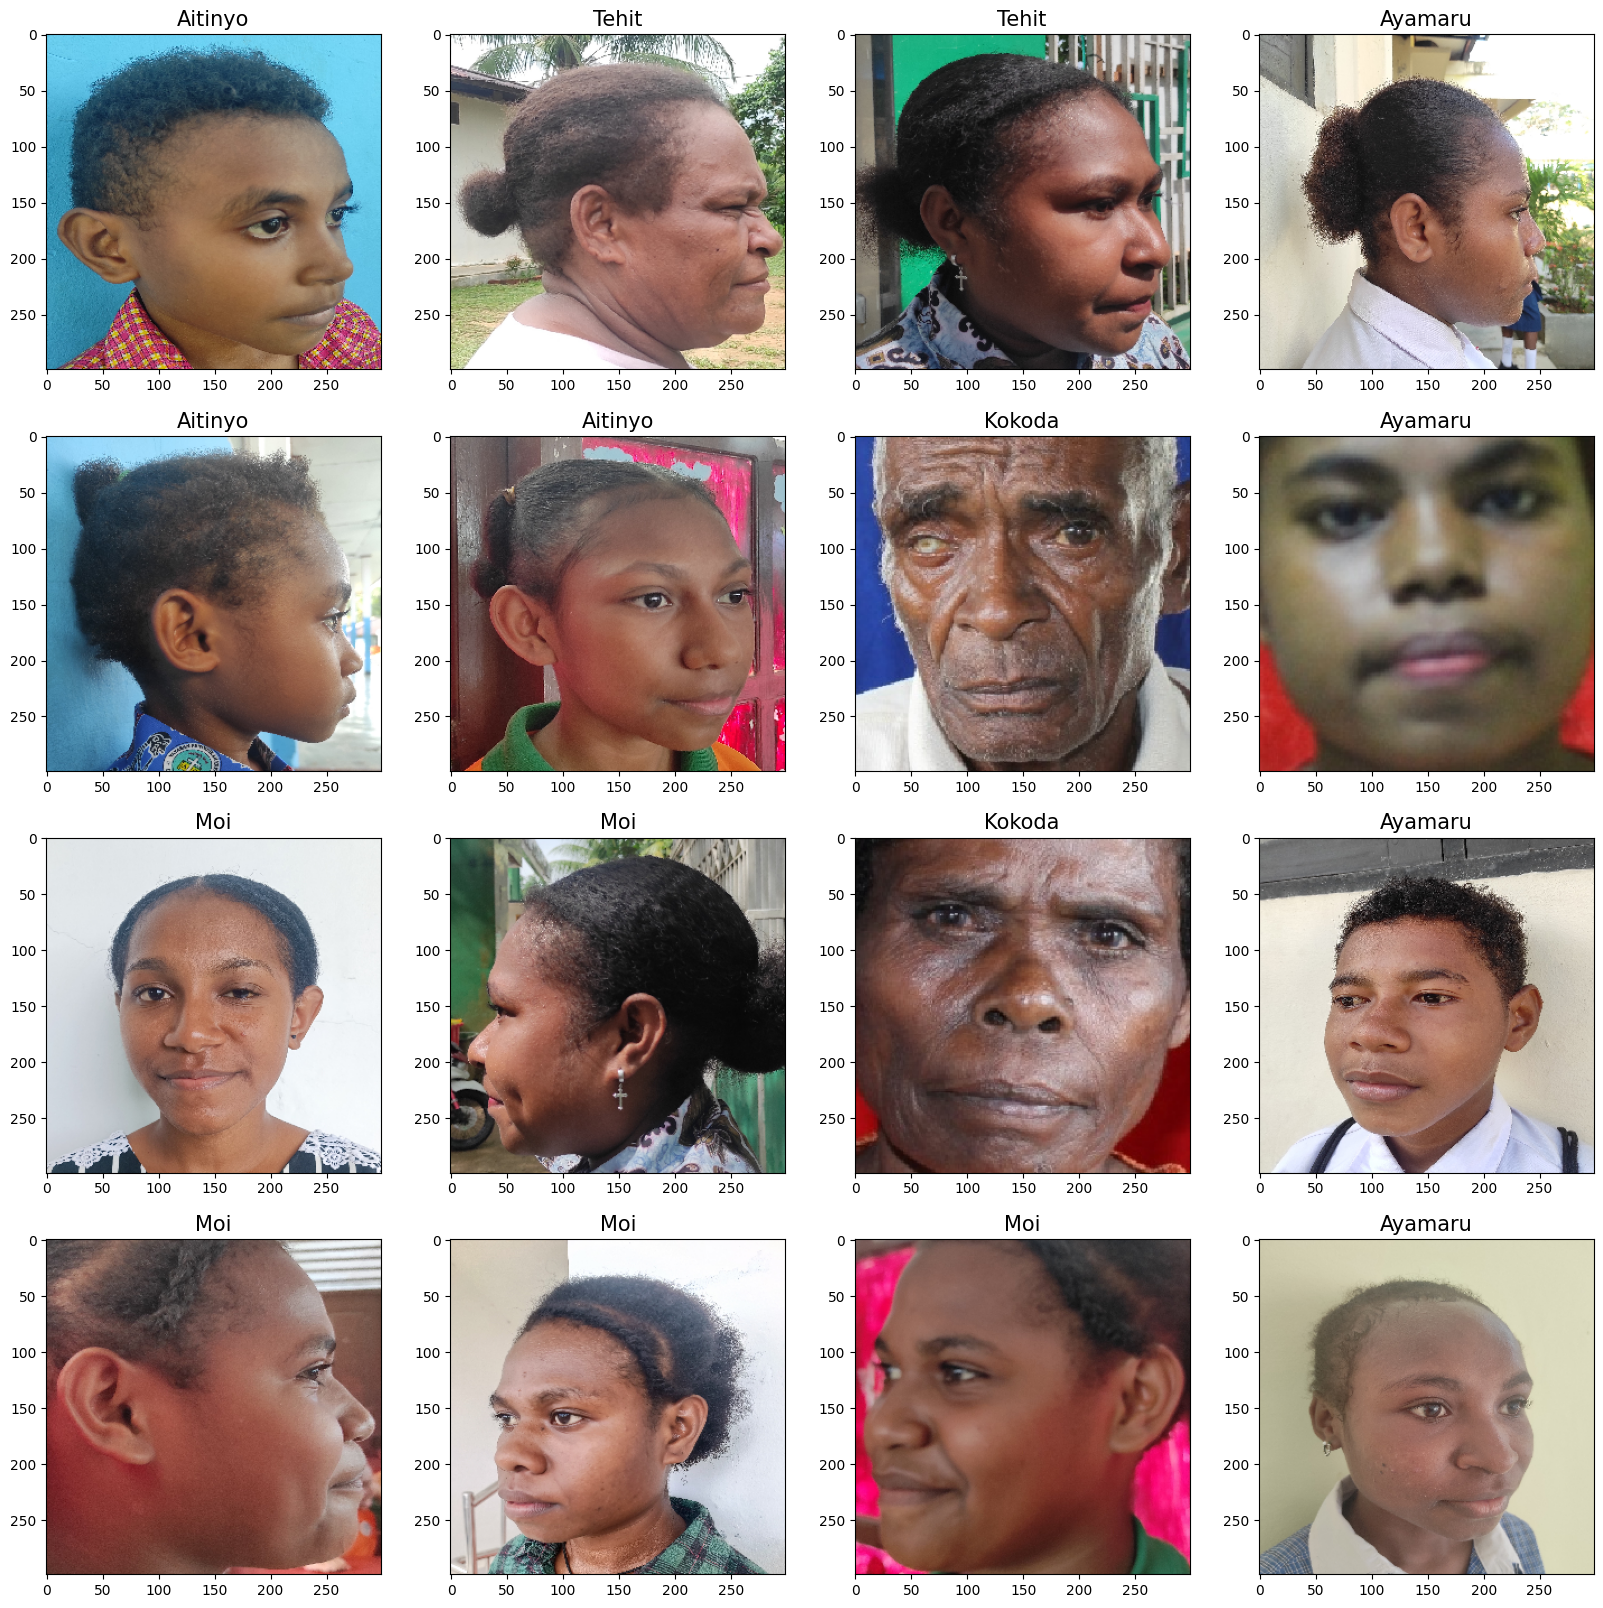

In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [21]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

for layer in base_model.layers:
     layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(5, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,397 (80.58 MB)

 Trainable params: 21,069,869 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

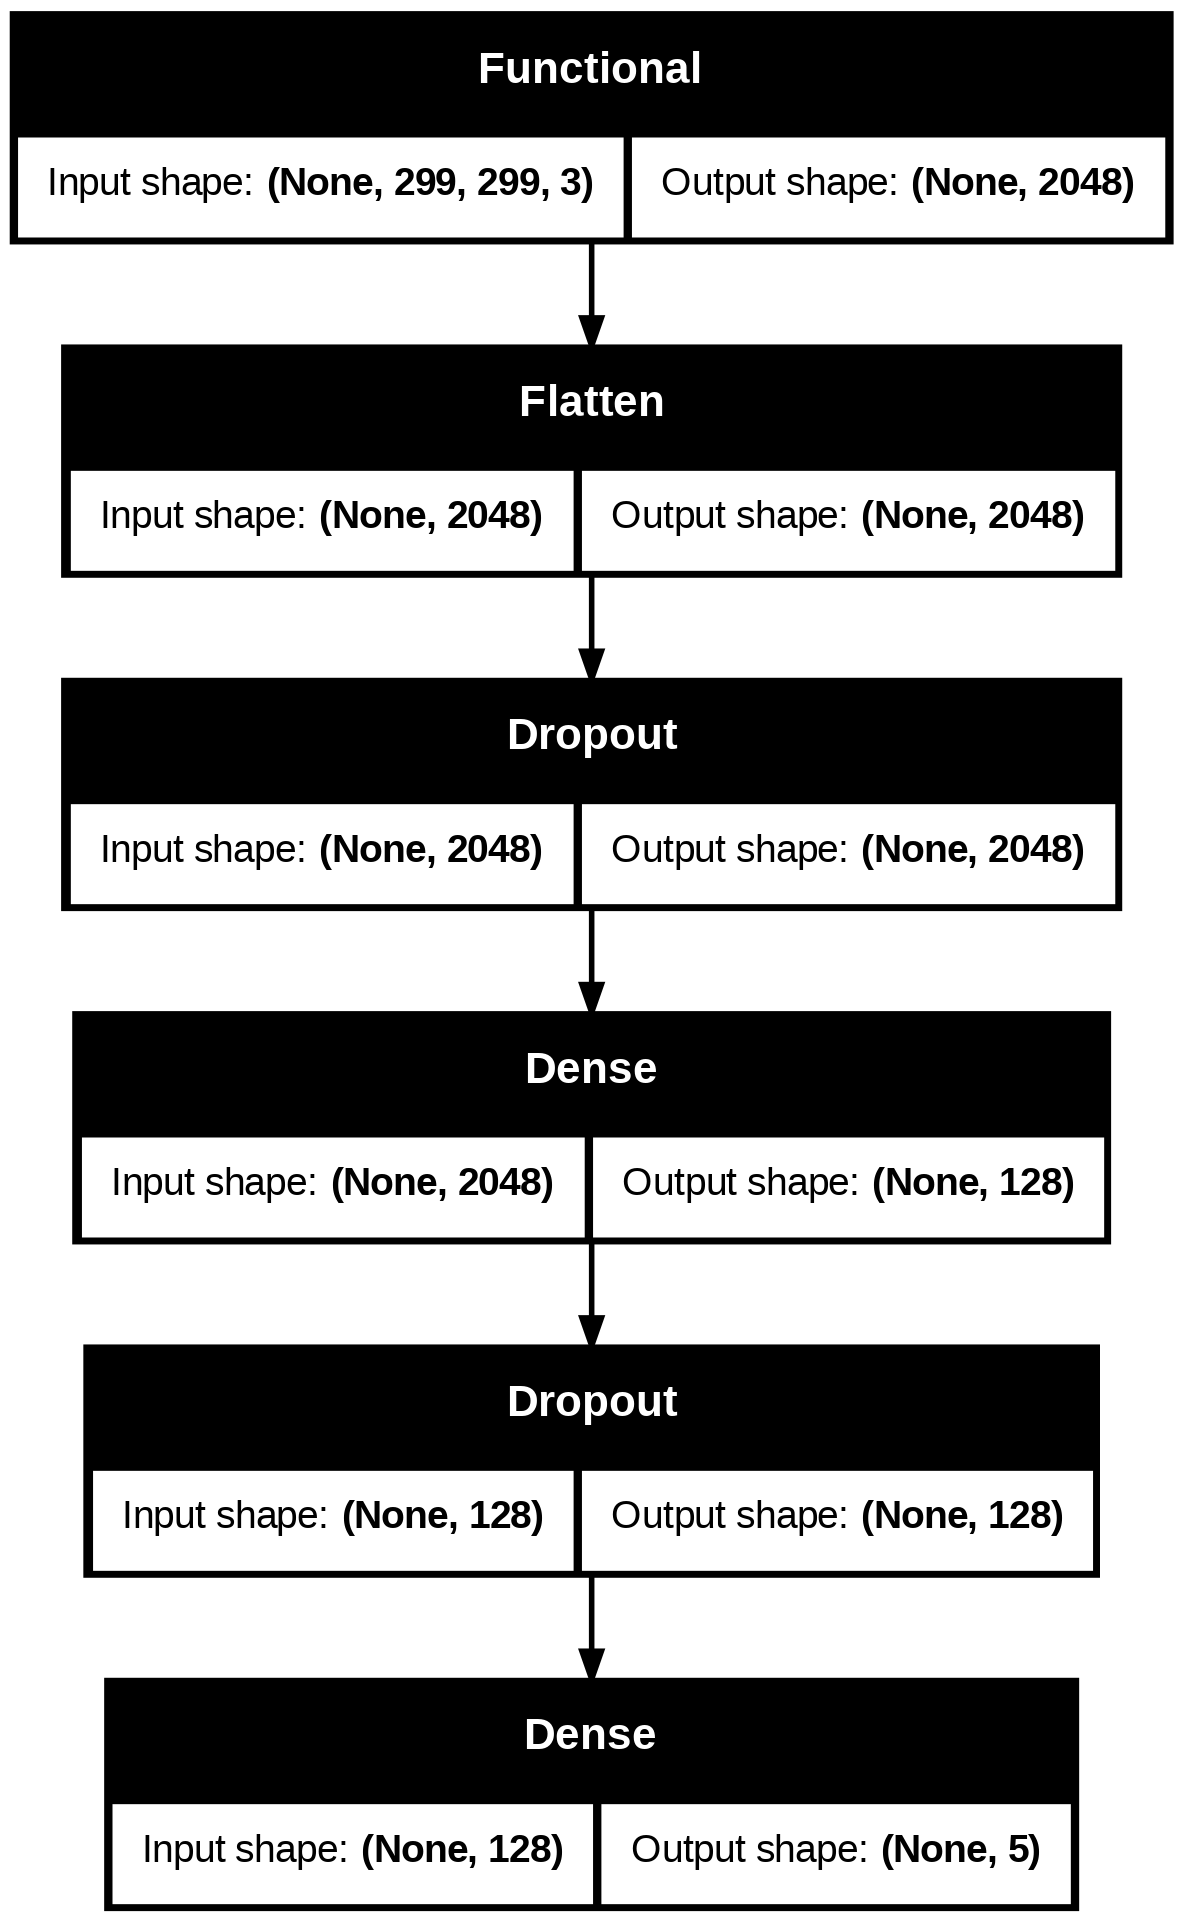

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [23]:
hist = model.fit(tr_gen,
                 epochs=50,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 583s 10s/step - accuracy: 0.3942 - loss: 1.6879 - precision_2: 0.5719 - recall_2: 0.1556 - val_accuracy: 0.3753 - val_loss: 2.9956 - val_precision_2: 0.3399 - val_recall_2: 0.2822
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 902ms/step - accuracy: 0.5777 - loss: 0.9889 - precision_2: 0.8961 - recall_2: 0.3485 - val_accuracy: 0.4301 - val_loss: 2.0723 - val_precision_2: 0.4558 - val_recall_2: 0.3671
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 921ms/step - accuracy: 0.7139 - loss: 0.6655 - precision_2: 0.8169 - recall_2: 0.5843 - val_accuracy: 0.4274 - val_loss: 2.1147 - val_precision_2: 0.4708 - val_recall_2: 0.3753
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 926ms/step - accuracy: 0.8327 - loss: 0.4349 - precision_2: 0.8985 - recall_2: 0.7753 - val_accuracy: 0.4603 - val_loss: 3.0124 - val_precision_2: 0.4602 - val_recall_2: 0.4438
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 937ms/step - accuracy: 0.8898 - loss: 0.3060 - precision_2: 0.9088 - recall_2: 0.86

In [24]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])

## 4.1 Visualize model performance

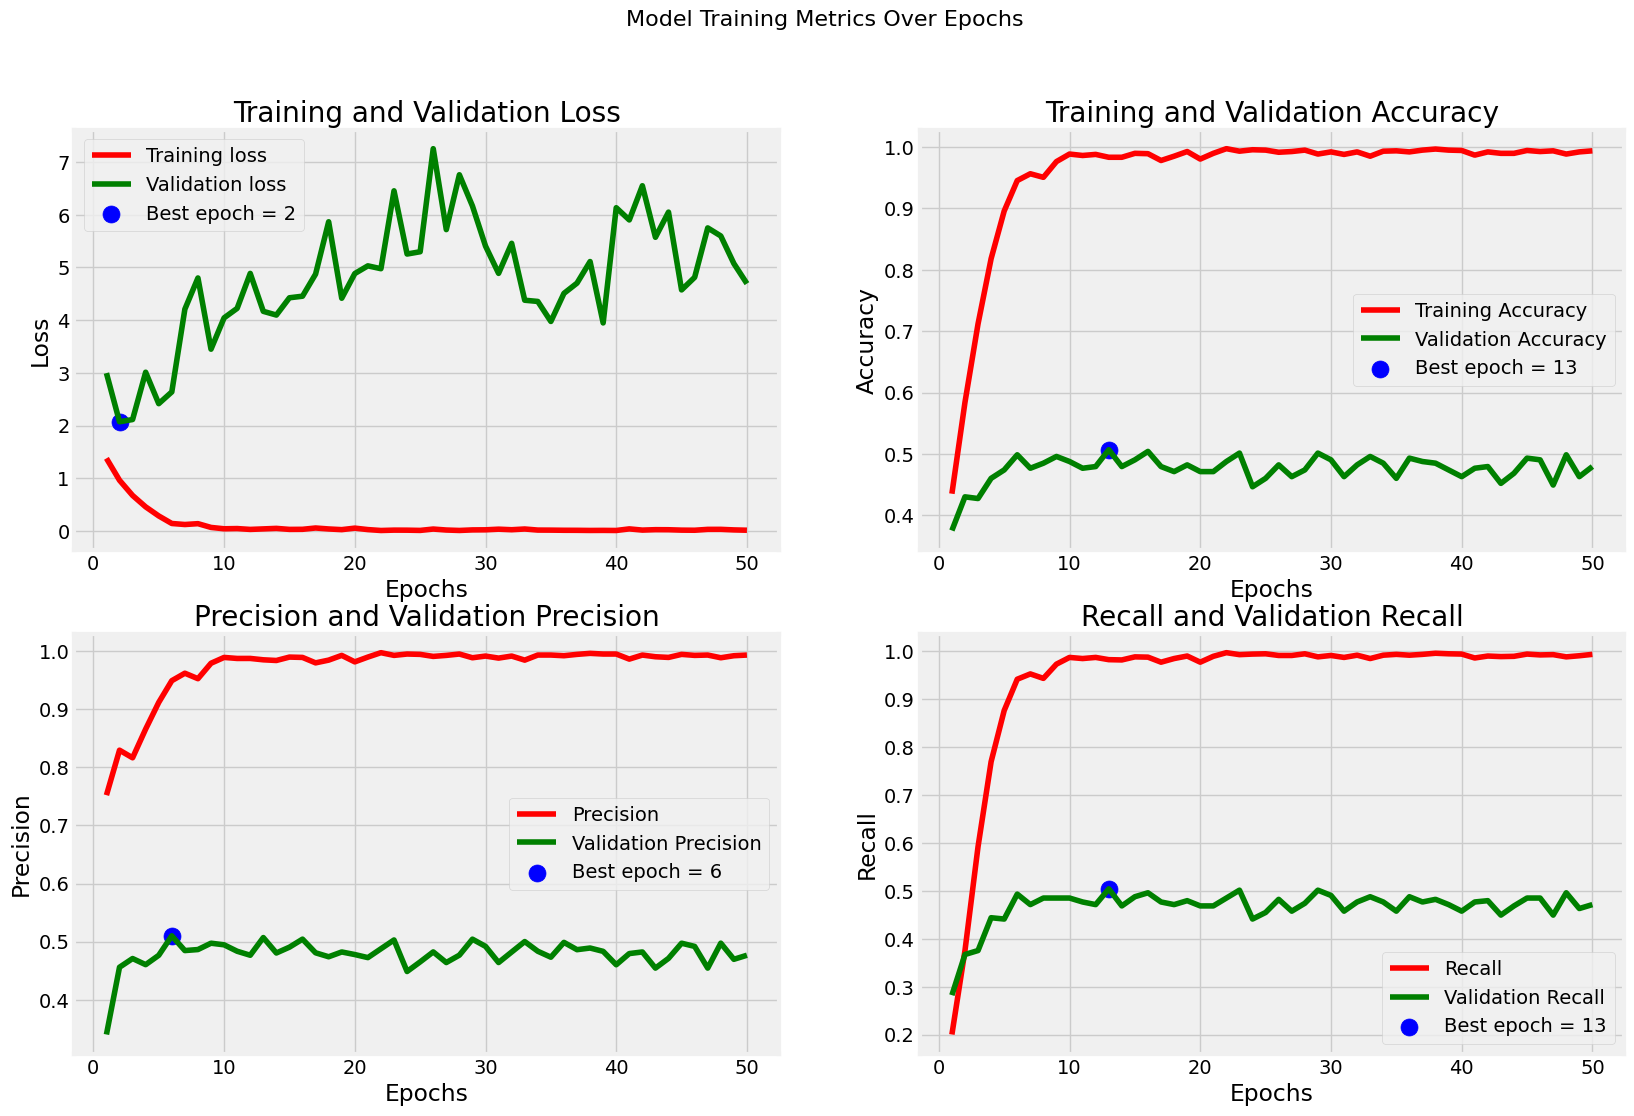

In [26]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision_2']
tr_recall = hist.history['recall_2']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision_2']
val_recall = hist.history['val_recall_2']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [27]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - accuracy: 0.9937 - loss: 0.0108 - precision_2: 0.9947 - recall_2: 0.9936
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 965ms/step - accuracy: 0.4540 - loss: 5.0729 - precision_2: 0.4544 - recall_2: 0.4513
23/23 ━━━━━━━━━━━━━━━━━━━━ 311s 14s/step - accuracy: 0.4631 - loss: 5.0207 - precision_2: 0.4707 - recall_2: 0.4592
Train Loss: 0.0106
Train Accuracy: 99.42%
--------------------
Validation Loss: 4.6739
Validation Accuracy: 47.67%
--------------------
Test Loss: 4.9895
Test Accuracy: 46.85%


In [28]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 537ms/step


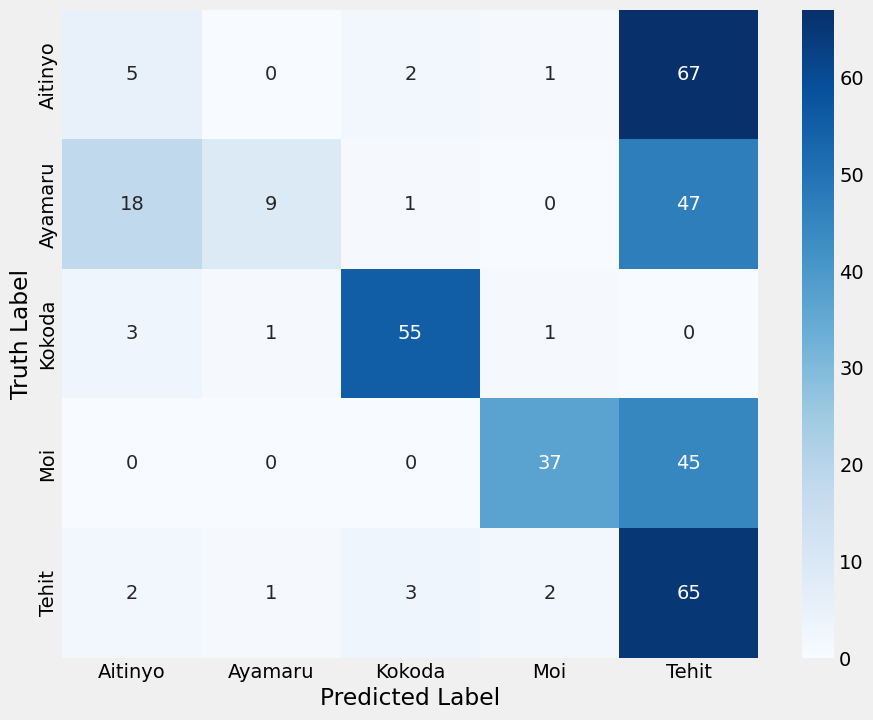

In [29]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [30]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.18      0.07      0.10        75
           1       0.82      0.12      0.21        75
           2       0.90      0.92      0.91        60
           3       0.90      0.45      0.60        82
           4       0.29      0.89      0.44        73

    accuracy                           0.47       365
   macro avg       0.62      0.49      0.45       365
weighted avg       0.61      0.47      0.44       365



## 5.2 Testing

In [31]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


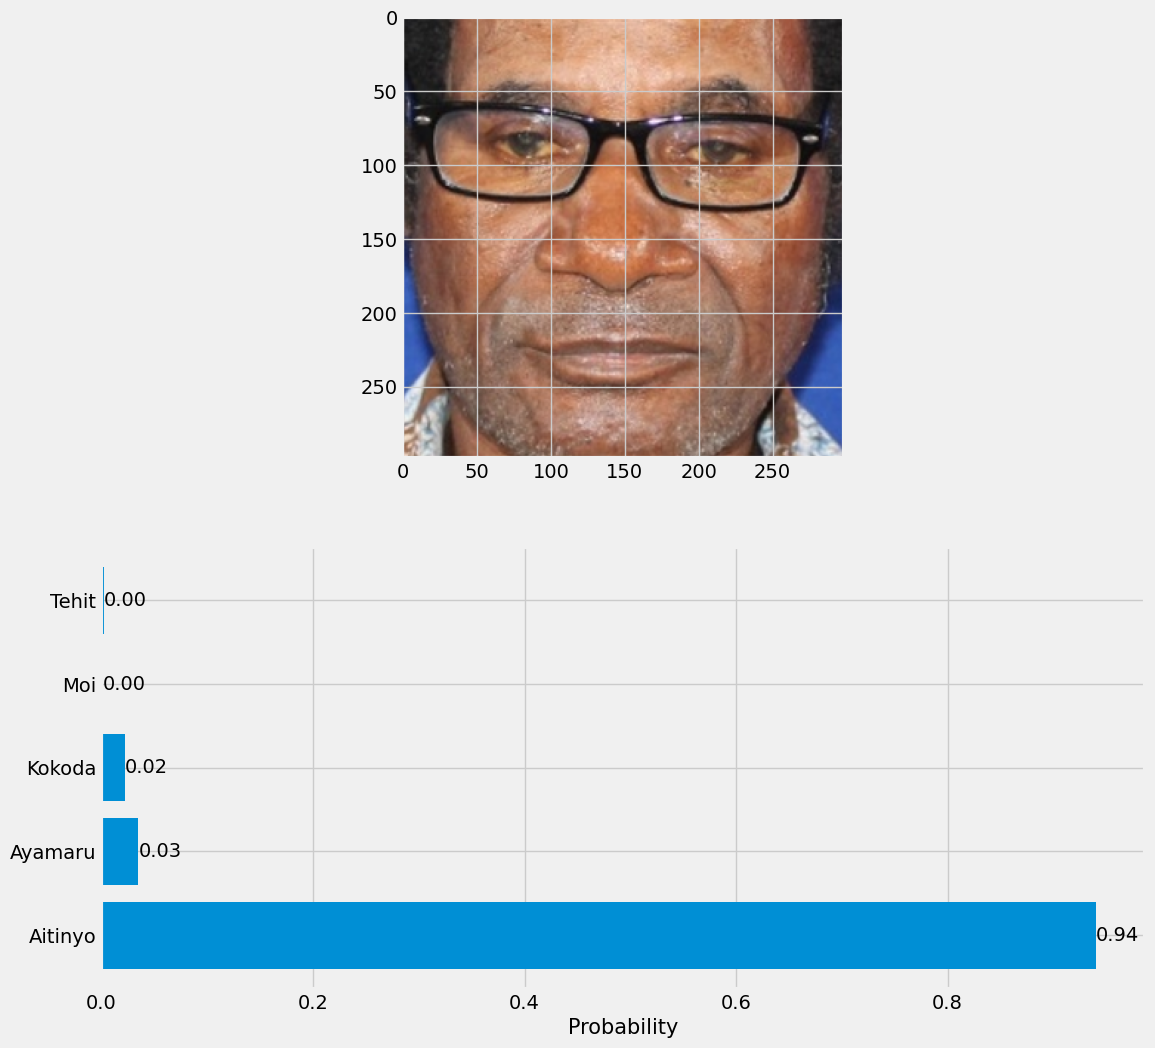

In [32]:
predict('/content/drive/MyDrive/datasetWajahsplit/Testing/Ayamaru/9204142608580001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


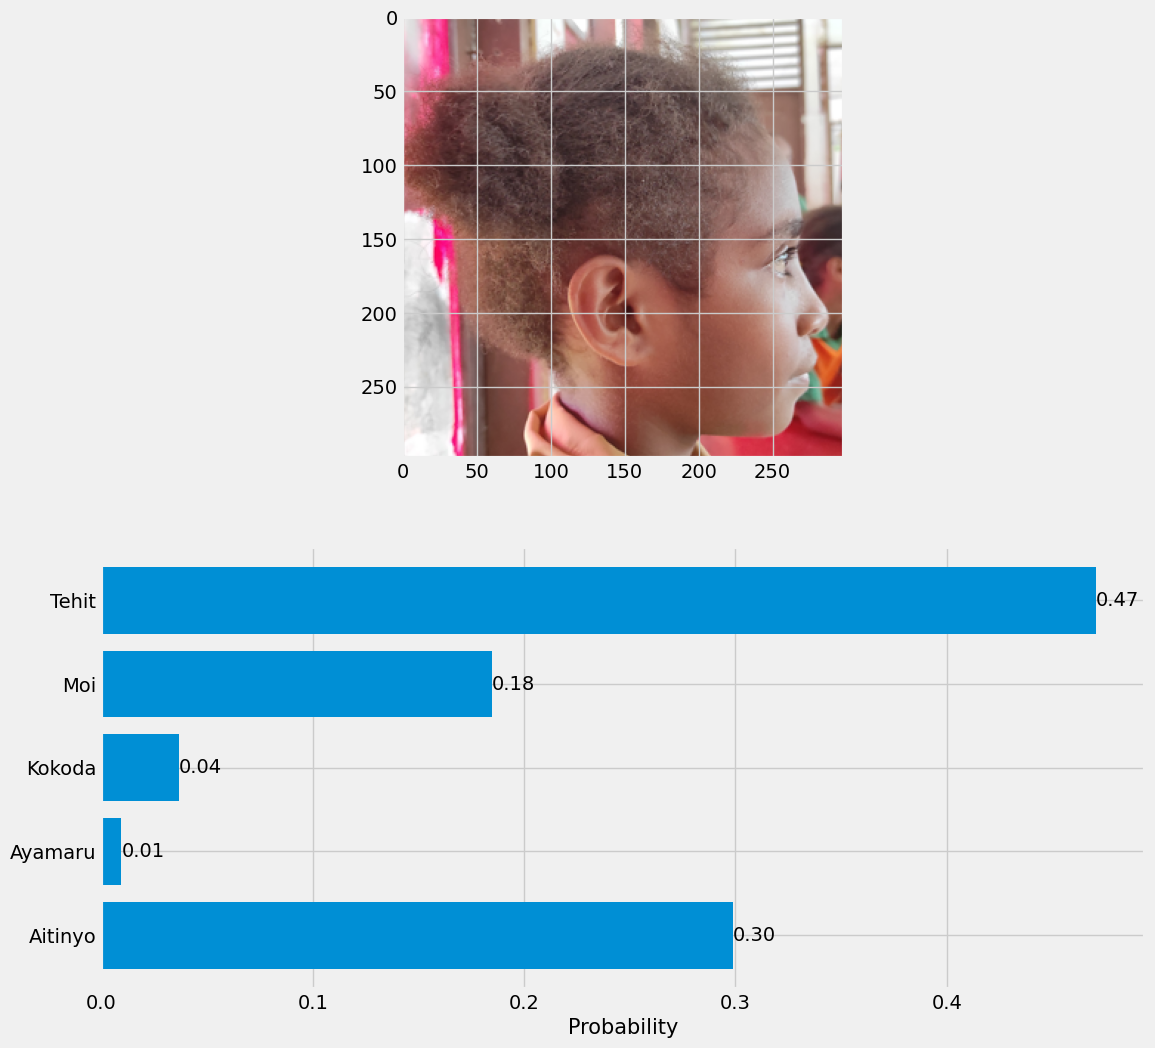

In [33]:
predict('/content/drive/MyDrive/datasetWajahsplit/Testing/Aitinyo/a1 (33).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


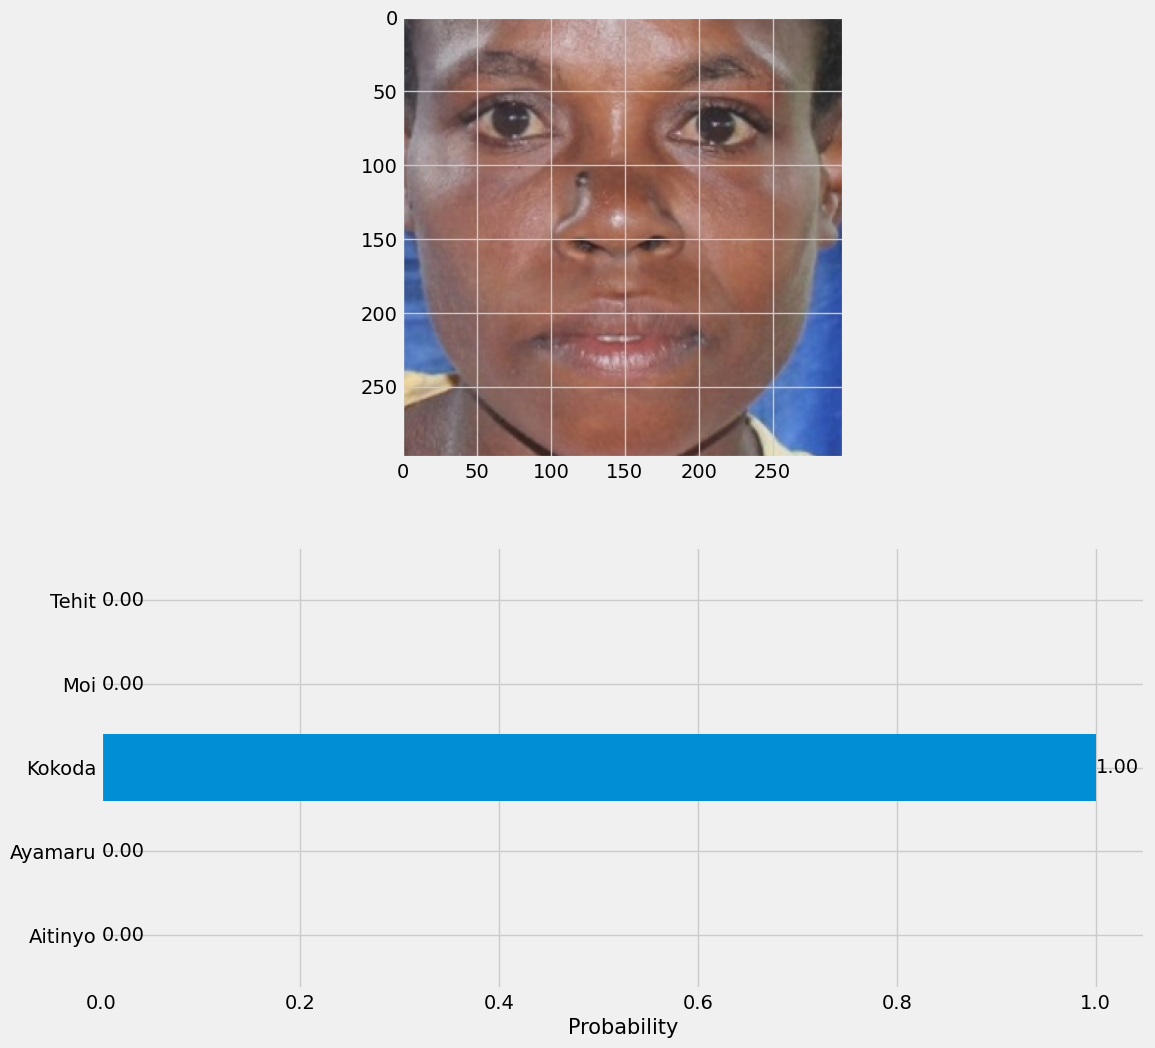

In [36]:
predict('/content/drive/MyDrive/datasetWajahsplit/Testing/Kokoda/gogoba94107891001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


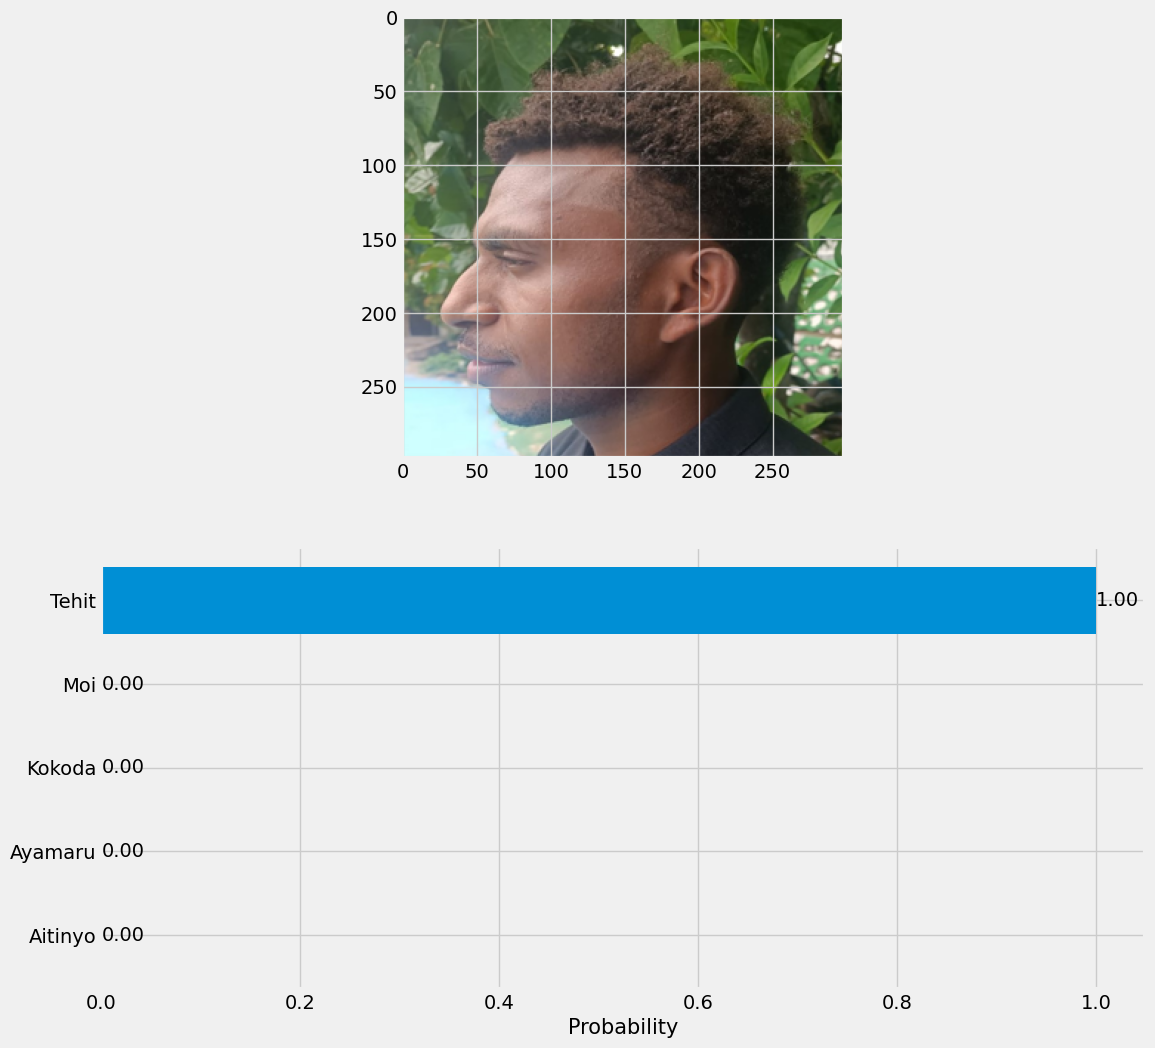

In [35]:
predict('/content/drive/MyDrive/datasetWajahsplit/Testing/Moi/d1 (73).jpg')